사용 중인 디바이스: cuda


Training Episodes:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

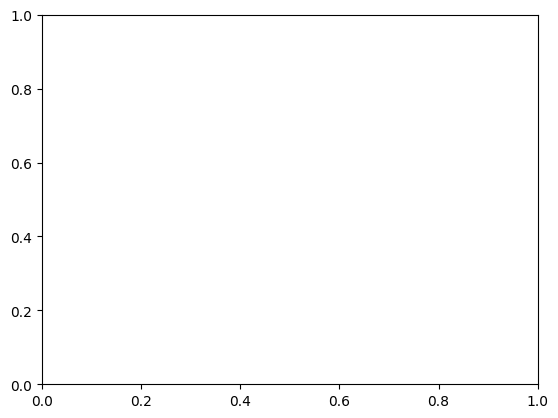

In [23]:
# 필요한 라이브러리 임포트
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

# CUDA 설정 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}")

# 1. 그리드 맵 로드 및 좌표 변환 함수 정의
grid_map = np.load(r"C:\baramproject\sibal\land_sea_grid_cartopy.npy")
n_rows, n_cols = grid_map.shape  # 810x710

# 위경도 범위
lon_min, lon_max = 120.0, 127.0
lat_min, lat_max = 30.0, 38.0

def latlon_to_grid(lat, lon):
    """위경도를 그리드 픽셀 좌표로 변환"""
    x = int((lon - lon_min) / (lon_max - lon_min) * (n_cols - 1))
    y = int((lat_max - lat) / (lat_max - lat_min) * (n_rows - 1))
    return y, x

# 시작점과 도착점 설정 (인천항과 상하이항)
start_point = latlon_to_grid(37.46036, 126.62360)  # 인천항
goal_point = latlon_to_grid(30.62828, 122.06400)   # 상하이항

# 2. 강화 학습 환경 정의
class NavigationEnv:
    def __init__(self, grid, start, goal):
        self.grid = grid
        self.start = start
        self.goal = goal
        self.agent_pos = start
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1),  # 상, 하, 좌, 우
                        (-1, -1), (-1, 1), (1, -1), (1, 1)]  # 대각선
        self.max_steps = 1000  # 최대 스텝 제한

    def reset(self, reverse=False):
        """환경 초기화, reverse=True면 목표와 시작점 반전"""
        if reverse:
            self.agent_pos = self.goal
            self.goal_pos = self.start
        else:
            self.agent_pos = self.start
            self.goal_pos = self.goal
        self.steps = 0
        return self._get_state()

    def _get_state(self):
        """현재 상태 반환: 에이전트 위치와 목표 위치"""
        return np.array([self.agent_pos[0], self.agent_pos[1], 
                         self.goal_pos[0], self.goal_pos[1]])

    def step(self, action):
        """행동 수행"""
        self.steps += 1
        new_pos = (self.agent_pos[0] + self.actions[action][0],
                   self.agent_pos[1] + self.actions[action][1])

        # 그리드 경계 및 육지 확인
        if (0 <= new_pos[0] < n_rows and 0 <= new_pos[1] < n_cols and 
            self.grid[new_pos[0], new_pos[1]] == 0):  # 바다일 경우만 이동
            self.agent_pos = new_pos
            reward = self._calculate_reward()
            done = self.agent_pos == self.goal_pos or self.steps >= self.max_steps
            return self._get_state(), reward, done
        else:  # 육지나 경계 밖
            return self._get_state(), -10, False

    def _calculate_reward(self):
        """보상 계산"""
        dist = np.sqrt((self.agent_pos[0] - self.goal_pos[0])**2 + 
                       (self.agent_pos[1] - self.goal_pos[1])**2)
        prev_dist = np.sqrt((self.agent_pos[0] + self.actions[-1][0] - self.goal_pos[0])**2 + 
                            (self.agent_pos[1] + self.actions[-1][1] - self.goal_pos[1])**2)
        reward = (prev_dist - dist) * 0.1  # 거리 감소에 비례한 보상
        if self.agent_pos == self.goal_pos:
            reward += 100  # 목표 도달 시 큰 보상
        reward -= 1  # 이동마다 작은 패널티 (최단 경로 유도)
        return reward

# 3. DQN 모델 정의
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# 4. 에이전트 정의
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # 할인율
        self.epsilon = 1.0  # 탐험률
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = DQN(state_size, action_size).to(device)
        self.target_model = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.update_target_model()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        # 메모리에서 배치 샘플링
        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        
        # 리스트를 NumPy 배열로 변환 후 텐서로 변환
        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(np.array(actions)).to(device)
        rewards = torch.FloatTensor(np.array(rewards)).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(np.array(dones)).to(device)

        # Q값 계산
        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_model(next_states).max(1)[0]
        targets = rewards + (self.gamma * next_q_values * (1 - dones))

        # 손실 계산 및 학습
        loss = nn.MSELoss()(q_values, targets.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# 5. 학습 루프
env = NavigationEnv(grid_map, start_point, goal_point)
agent = DQNAgent(state_size=4, action_size=8)
episodes = 500
batch_size = 32
rewards_history = []

plt.ion()  # 실시간 플롯 활성화
fig, ax = plt.subplots()

for e in tqdm(range(episodes), desc="Training Episodes"):
    state = env.reset(reverse=(e % 2 == 1))  # 왕복 설정
    total_reward = 0
    done = False
    
    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.replay(batch_size)
    
    agent.update_target_model()
    rewards_history.append(total_reward)
    
    # 실시간 리워드 그래프 갱신
    clear_output(wait=True)
    ax.clear()
    ax.plot(rewards_history, label='Total Reward')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title('Training Progress')
    ax.legend()
    plt.pause(0.001)
    tqdm.write(f"Episode {e+1}/{episodes} - Reward: {total_reward:.2f} - Epsilon: {agent.epsilon:.2f}")

plt.ioff()
plt.show()

# 모델 저장
torch.save(agent.model.state_dict(), r"C:\baramproject\trained_model\sibal7\dqn_navigation_model.pth")
print("모델 저장 완료: dqn_navigation_model.pth")

# 6. 예측 함수
def predict_path(agent, env, start, goal):
    env.reset()
    env.agent_pos = start
    env.goal_pos = goal
    state = env._get_state()
    path = [start]
    done = False
    
    while not done:
        action = agent.act(state)
        state, reward, done = env.step(action)
        path.append((env.agent_pos[0], env.agent_pos[1]))
        if len(path) > env.max_steps:
            break
    
    return path

# 테스트: 인천항 -> 상하이항 경로 예측
learned_path = predict_path(agent, env, start_point, goal_point)
print("예측된 경로 (픽셀 좌표):", learned_path)

# 경로 시각화
plt.figure(figsize=(10, 8))
plt.imshow(grid_map, cmap='gray', origin='upper')
path_y, path_x = zip(*learned_path)
plt.plot(path_x, path_y, 'r.-', label='Predicted Path')
plt.scatter([start_point[1], goal_point[1]], [start_point[0], goal_point[0]], 
            c='yellow', label='Start/Goal')
plt.legend()
plt.title('Optimal Navigation Path')
plt.show()